# Debug GestureNet OpenCL implement with PyOpenCL and PyTorch
Partial code are copied heavily from https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py  
SqueezeNet Paper:https://arxiv.org/abs/1602.07360  
SqueezeNet 1.1 model from https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1   
SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters than SqueezeNet 1.0, without sacrificing accuracy.


In [1]:
#some set up
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import math
import time
from matplotlib.pyplot import imshow
%matplotlib inline

## Test top-1 accuracy on pytorch pre-trained SqueezeNet v1.1 

### Build fire unit and SqueezeNet model

In [2]:
# squeeze_planes(1x1 conv) - (expand1x1_planes + expand3x3_planes)
class Fire(nn.Module):
    
    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))], 1)

class SqueezeNet(nn.Module):
    
    def __init__(self, num_classes=11):
        super(SqueezeNet, self).__init__()
        
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )
        # Final convolution is initialized differently form the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AvgPool2d(13, stride=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        
        return x.view(x.size(0), self.num_classes)

### Load validation image: ILSVRC2012 validation set

In [3]:
# data loading code
# batch_size 64 consumes about 3.3GB of gpu memory 
cudnn.benchmark = True

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std = [ 0.229, 0.224, 0.225 ]),
])

val_batch_size = 10
valdir = './imagenet/val/'
val = datasets.ImageFolder(valdir, transform)

val_loader = torch.utils.data.DataLoader(val, batch_size=val_batch_size,shuffle=False, pin_memory = True, num_workers=2)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './imagenet/val/'

### Calculate top-1 accuracy of the pre-trained model

In [4]:
model = SqueezeNet()
model.load_state_dict(torch.load('GestureNet.pth'))

#model.cuda()# using gpu
model.eval()# for dropout layer

# correct = 0.0
# total = 0.0
# for i, (images, labels) in enumerate(val_loader):
#     images = Variable(images)
    
#     # get output
#     output = model(images)
#     _, predicted = torch.max(output.data, 1)
#     total += labels.size(0)
#     correct += (predicted.cpu() == labels).sum()
    
# acc_val = 100.0 * correct / total
# print("Top-1 accuracy on validation set: %.4f" % acc_val)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

## Test if the OpenCL implement is correct
By comprare the result of OpenCL implement and PyTorch implement using a single image as input  
error = ((OpenCL_implement_class_socores - PyTorch_implement_class_socores) ^ 2).sum(element_wise)  
If the OpenCL implement is correct, error should be relativly small.

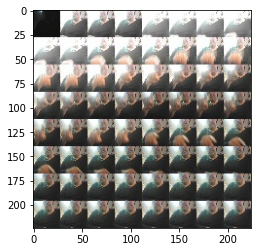

In [5]:
# load the test image
im_path = r'circle.jpg'
im = Image.open(im_path)

#visualize the image
imshow(im)

#preprocess of the imput image
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                         std = [ 0.5, 0.5, 0.5 ]),
])
im_input = transform(im)

#add a new axis for pytorch
im_input = im_input.numpy()
im_input = im_input[np.newaxis,:]
im_input = torch.from_numpy(im_input)

In [6]:
model.cpu()
im_input_torch = Variable(im_input)
im_output_torch = model(im_input_torch)
_, predicted = torch.max(im_output_torch.data, 1)
print('the label index prediction of pytorch implement: %d' % predicted.numpy()[0])

the label index prediction of pytorch implement: 10


### Load OpenCL implement
deviceinfo.py and partial pyopencl code are from Hands On OpenCL  
https://handsonopencl.github.io/

#### Step1: OpenCL preparation

In [7]:
# OpenCL setup
import pyopencl as cl
import deviceinfo
from time import time

In [8]:
# Ask the user to select a platform/device on the CLI
context = cl.create_some_context()

# Print out device info
deviceinfo.output_device_info(context.devices[0])

# Create a command queue
queue = cl.CommandQueue(context)

Device is NVIDIA GeForce GTX 1650 TiGPU from NVIDIA Corporation with a max of 16 compute units


#### Step 2: import parameters from pytorch implement

In [9]:
params = model.state_dict() 

#remove # to see the params index
for k,v in params.items():
    #print parameter name
    print(k,params[k].numpy().shape)

conv1_weight = params['features.0.weight'].numpy().reshape(-1)
conv1_bias = params['features.0.bias'].numpy()

#fire - fire - maxpool block 1
fire1_squeeze_weight = params['features.3.squeeze.weight'].numpy().reshape(-1)
fire1_squeeze_bias = params['features.3.squeeze.bias'].numpy()

fire1_expand1x1_weight = params['features.3.expand1x1.weight'].numpy().reshape(-1)
fire1_expand1x1_bias = params['features.3.expand1x1.bias'].numpy()

fire1_expand3x3_weight = params['features.3.expand3x3.weight'].numpy().reshape(-1)
fire1_expand3x3_bias = params['features.3.expand3x3.bias'].numpy()

fire2_squeeze_weight = params['features.4.squeeze.weight'].numpy().reshape(-1)
fire2_squeeze_bias = params['features.4.squeeze.bias'].numpy()

fire2_expand1x1_weight = params['features.4.expand1x1.weight'].numpy().reshape(-1)
fire2_expand1x1_bias = params['features.4.expand1x1.bias'].numpy()

fire2_expand3x3_weight = params['features.4.expand3x3.weight'].numpy().reshape(-1)
fire2_expand3x3_bias = params['features.4.expand3x3.bias'].numpy()

#fire - fire - maxpool block 2
fire3_squeeze_weight = params['features.6.squeeze.weight'].numpy().reshape(-1)
fire3_squeeze_bias = params['features.6.squeeze.bias'].numpy()

fire3_expand1x1_weight = params['features.6.expand1x1.weight'].numpy().reshape(-1)
fire3_expand1x1_bias = params['features.6.expand1x1.bias'].numpy()

fire3_expand3x3_weight = params['features.6.expand3x3.weight'].numpy().reshape(-1)
fire3_expand3x3_bias = params['features.6.expand3x3.bias'].numpy()

fire4_squeeze_weight = params['features.7.squeeze.weight'].numpy().reshape(-1)
fire4_squeeze_bias = params['features.7.squeeze.bias'].numpy()

fire4_expand1x1_weight = params['features.7.expand1x1.weight'].numpy().reshape(-1)
fire4_expand1x1_bias = params['features.7.expand1x1.bias'].numpy()

fire4_expand3x3_weight = params['features.7.expand3x3.weight'].numpy().reshape(-1)
fire4_expand3x3_bias = params['features.7.expand3x3.bias'].numpy()

#fire - fire - fire - fire block 3
fire5_squeeze_weight = params['features.9.squeeze.weight'].numpy().reshape(-1)
fire5_squeeze_bias = params['features.9.squeeze.bias'].numpy()

fire5_expand1x1_weight = params['features.9.expand1x1.weight'].numpy().reshape(-1)
fire5_expand1x1_bias = params['features.9.expand1x1.bias'].numpy()

fire5_expand3x3_weight = params['features.9.expand3x3.weight'].numpy().reshape(-1)
fire5_expand3x3_bias = params['features.9.expand3x3.bias'].numpy()

fire6_squeeze_weight = params['features.10.squeeze.weight'].numpy().reshape(-1)
fire6_squeeze_bias = params['features.10.squeeze.bias'].numpy()

fire6_expand1x1_weight = params['features.10.expand1x1.weight'].numpy().reshape(-1)
fire6_expand1x1_bias = params['features.10.expand1x1.bias'].numpy()

fire6_expand3x3_weight = params['features.10.expand3x3.weight'].numpy().reshape(-1)
fire6_expand3x3_bias = params['features.10.expand3x3.bias'].numpy()

fire7_squeeze_weight = params['features.11.squeeze.weight'].numpy().reshape(-1)
fire7_squeeze_bias = params['features.11.squeeze.bias'].numpy()

fire7_expand1x1_weight = params['features.11.expand1x1.weight'].numpy().reshape(-1)
fire7_expand1x1_bias = params['features.11.expand1x1.bias'].numpy()

fire7_expand3x3_weight = params['features.11.expand3x3.weight'].numpy().reshape(-1)
fire7_expand3x3_bias = params['features.11.expand3x3.bias'].numpy()

fire8_squeeze_weight = params['features.12.squeeze.weight'].numpy().reshape(-1)
fire8_squeeze_bias = params['features.12.squeeze.bias'].numpy()

fire8_expand1x1_weight = params['features.12.expand1x1.weight'].numpy().reshape(-1)
fire8_expand1x1_bias = params['features.12.expand1x1.bias'].numpy()

fire8_expand3x3_weight = params['features.12.expand3x3.weight'].numpy().reshape(-1)
fire8_expand3x3_bias = params['features.12.expand3x3.bias'].numpy()

classifier_conv_weight = params['classifier.1.weight'].numpy().reshape(-1)
classifier_conv_bias = params['classifier.1.bias'].numpy()

features.0.weight (64, 3, 3, 3)
features.0.bias (64,)
features.3.squeeze.weight (16, 64, 1, 1)
features.3.squeeze.bias (16,)
features.3.expand1x1.weight (64, 16, 1, 1)
features.3.expand1x1.bias (64,)
features.3.expand3x3.weight (64, 16, 3, 3)
features.3.expand3x3.bias (64,)
features.4.squeeze.weight (16, 128, 1, 1)
features.4.squeeze.bias (16,)
features.4.expand1x1.weight (64, 16, 1, 1)
features.4.expand1x1.bias (64,)
features.4.expand3x3.weight (64, 16, 3, 3)
features.4.expand3x3.bias (64,)
features.6.squeeze.weight (32, 128, 1, 1)
features.6.squeeze.bias (32,)
features.6.expand1x1.weight (128, 32, 1, 1)
features.6.expand1x1.bias (128,)
features.6.expand3x3.weight (128, 32, 3, 3)
features.6.expand3x3.bias (128,)
features.7.squeeze.weight (32, 256, 1, 1)
features.7.squeeze.bias (32,)
features.7.expand1x1.weight (128, 32, 1, 1)
features.7.expand1x1.bias (128,)
features.7.expand3x3.weight (128, 32, 3, 3)
features.7.expand3x3.bias (128,)
features.9.squeeze.weight (48, 256, 1, 1)
features.

In [10]:
print(params['classifier.1.weight'][10][510][0][0])

tensor(0.0455)


Creat OpenCL memory object

In [11]:
h_sample = im_input.numpy().reshape(-1)
h_result_conv = np.empty(1 * 64 * 111 * 111).astype(np.float32)
h_result_pool1 = np.empty(1 * 64 * 55 * 55).astype(np.float32)

h_result_fire1_squeeze = np.empty(1 * 16 * 55 * 55).astype(np.float32)
h_result_fire1_expand = np.empty(1 * 128 * 55 * 55).astype(np.float32)
h_result_fire2_squeeze = np.empty(1 * 16 * 55 * 55).astype(np.float32)
h_result_fire2_expand = np.empty(1 * 128 * 55 * 55).astype(np.float32)
h_result_pool2 = np.empty(1 * 128 * 27 * 27).astype(np.float32)

h_result_fire3_squeeze = np.empty(1 * 32 * 27 * 27).astype(np.float32)
h_result_fire3_expand = np.empty(1 * 256 * 27 * 27).astype(np.float32)
h_result_fire4_squeeze = np.empty(1 * 32 * 27 * 27).astype(np.float32)
h_result_fire4_expand = np.empty(1 * 256 * 27 * 27).astype(np.float32)
h_result_pool3 = np.empty(1 * 256 * 13 * 13).astype(np.float32)

h_result_fire5_squeeze = np.empty(1 * 48 * 13 * 13).astype(np.float32)
h_result_fire5_expand = np.empty(1 * 384 * 13 * 13).astype(np.float32)
h_result_fire6_squeeze = np.empty(1 * 48 * 13 * 13).astype(np.float32)
h_result_fire6_expand = np.empty(1 * 384 * 13 * 13).astype(np.float32)
h_result_fire7_squeeze = np.empty(1 * 64 * 13 * 13).astype(np.float32)
h_result_fire7_expand = np.empty(1 * 512 * 13 * 13).astype(np.float32)
h_result_fire8_squeeze = np.empty(1 * 64 * 13 * 13).astype(np.float32)
h_result_fire8_expand = np.empty(1 * 512 * 13 * 13).astype(np.float32)

h_result_classifier_conv = np.empty(1 * 11 * 13 * 13).astype(np.float32)
h_result_classifier = np.empty(1 * 11).astype(np.float32)

# device input buffer
d_sample = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_sample)

# device conv1 buffers 
d_conv1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv1_weight)
d_conv1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv1_bias)

d_fire1_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire1_squeeze_weight)
d_fire1_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire1_squeeze_bias)
d_fire1_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire1_expand1x1_weight)
d_fire1_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire1_expand1x1_bias)
d_fire1_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire1_expand3x3_weight)
d_fire1_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire1_expand3x3_bias)

d_fire2_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire2_squeeze_weight)
d_fire2_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire2_squeeze_bias)
d_fire2_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire2_expand1x1_weight)
d_fire2_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire2_expand1x1_bias)
d_fire2_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire2_expand3x3_weight)
d_fire2_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire2_expand3x3_bias)

d_fire3_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire3_squeeze_weight)
d_fire3_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire3_squeeze_bias)
d_fire3_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire3_expand1x1_weight)
d_fire3_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire3_expand1x1_bias)
d_fire3_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire3_expand3x3_weight)
d_fire3_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire3_expand3x3_bias)

d_fire4_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire4_squeeze_weight)
d_fire4_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire4_squeeze_bias)
d_fire4_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire4_expand1x1_weight)
d_fire4_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire4_expand1x1_bias)
d_fire4_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire4_expand3x3_weight)
d_fire4_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire4_expand3x3_bias)

d_fire5_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire5_squeeze_weight)
d_fire5_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire5_squeeze_bias)
d_fire5_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire5_expand1x1_weight)
d_fire5_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire5_expand1x1_bias)
d_fire5_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire5_expand3x3_weight)
d_fire5_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire5_expand3x3_bias)

d_fire6_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire6_squeeze_weight)
d_fire6_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire6_squeeze_bias)
d_fire6_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire6_expand1x1_weight)
d_fire6_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire6_expand1x1_bias)
d_fire6_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire6_expand3x3_weight)
d_fire6_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire6_expand3x3_bias)

d_fire7_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire7_squeeze_weight)
d_fire7_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire7_squeeze_bias)
d_fire7_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire7_expand1x1_weight)
d_fire7_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire7_expand1x1_bias)
d_fire7_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire7_expand3x3_weight)
d_fire7_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire7_expand3x3_bias)

d_fire8_squeeze_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire8_squeeze_weight)
d_fire8_squeeze_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire8_squeeze_bias)
d_fire8_expand1x1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire8_expand1x1_weight)
d_fire8_expand1x1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire8_expand1x1_bias)
d_fire8_expand3x3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire8_expand3x3_weight)
d_fire8_expand3x3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=fire8_expand3x3_bias)

d_classifier_conv_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_conv_weight)
d_classifier_conv_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_conv_bias)

d_result_conv = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_conv.nbytes)
d_result_pool1 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_pool1.nbytes)

d_result_fire1_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire1_squeeze.nbytes)
d_result_fire1_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire1_expand.nbytes)
d_result_fire2_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire2_squeeze.nbytes)
d_result_fire2_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire2_expand.nbytes)
d_result_pool2 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_pool2.nbytes)

d_result_fire3_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire3_squeeze.nbytes)
d_result_fire3_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire3_expand.nbytes)
d_result_fire4_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire4_squeeze.nbytes)
d_result_fire4_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire4_expand.nbytes)
d_result_pool3 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_pool3.nbytes)

d_result_fire5_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire5_squeeze.nbytes)
d_result_fire5_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire5_expand.nbytes)
d_result_fire6_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire6_squeeze.nbytes)
d_result_fire6_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire6_expand.nbytes)
d_result_fire7_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire7_squeeze.nbytes)
d_result_fire7_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire7_expand.nbytes)
d_result_fire8_squeeze = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire8_squeeze.nbytes)
d_result_fire8_expand = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_fire8_expand.nbytes)

d_result_classifier_conv = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_classifier_conv.nbytes)
d_result_classifier = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_classifier.nbytes)

#### Step 3: creat kernels
Creat & build program

In [12]:
kernelSource = open("gesturenet.cl").read()
program = cl.Program(context, kernelSource).build()

Creat kernels

In [15]:
conv3x3 = program.conv2d3x3
conv3x3.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, np.int32, np.int32, np.int32, \
                               None, None, None, None])

maxpool = program.maxpool2d
maxpool.set_scalar_arg_dtypes([np.int32, np.int32, None, None])

conv1x1 = program.conv2d1x1
conv1x1.set_scalar_arg_dtypes([np.int32, np.int32,np.int32, \
                               None, None, None, None])

avgpool = program.avgpool2d
avgpool.set_scalar_arg_dtypes([np.int32,np.int32,None, None])

Run OpenCL implement  

In [16]:
rtime = time()
#first conv layer
conv3x3(queue,(64,), None, 3, 224, 0, 2, 0, 111, d_sample, d_conv1_weight, d_conv1_bias, d_result_conv)
maxpool(queue,(64,), None, 111, 55, d_result_conv, d_result_pool1)

#block1
conv1x1(queue,(16,), None, 64, 55, 55, d_result_pool1, d_fire1_squeeze_weight, d_fire1_squeeze_bias, d_result_fire1_squeeze)
conv1x1(queue,(64,), None, 16, 55, 55, d_result_fire1_squeeze, d_fire1_expand1x1_weight, d_fire1_expand1x1_bias, d_result_fire1_expand)
conv3x3(queue,(64,), None, 16, 55, 1, 1, 64, 55, d_result_fire1_squeeze, d_fire1_expand3x3_weight, d_fire1_expand3x3_bias, d_result_fire1_expand)

conv1x1(queue,(16,), None, 128, 55, 55, d_result_fire1_expand, d_fire2_squeeze_weight, d_fire2_squeeze_bias, d_result_fire2_squeeze)
conv1x1(queue,(64,), None, 16, 55, 55, d_result_fire2_squeeze, d_fire2_expand1x1_weight, d_fire2_expand1x1_bias, d_result_fire2_expand)
conv3x3(queue,(64,), None, 16, 55, 1, 1, 64, 55, d_result_fire2_squeeze, d_fire2_expand3x3_weight, d_fire2_expand3x3_bias, d_result_fire2_expand)

maxpool(queue,(128,), None, 55, 27, d_result_fire2_expand, d_result_pool2)

#block2
conv1x1(queue,(32,), None, 128, 27, 27, d_result_pool2, d_fire3_squeeze_weight, d_fire3_squeeze_bias, d_result_fire3_squeeze)
conv1x1(queue,(128,), None, 32, 27, 27, d_result_fire3_squeeze, d_fire3_expand1x1_weight, d_fire3_expand1x1_bias, d_result_fire3_expand)
conv3x3(queue,(128,), None, 32, 27, 1, 1, 128, 27, d_result_fire3_squeeze, d_fire3_expand3x3_weight, d_fire3_expand3x3_bias, d_result_fire3_expand)

conv1x1(queue,(32,), None, 256, 27, 27, d_result_fire3_expand, d_fire4_squeeze_weight, d_fire4_squeeze_bias, d_result_fire4_squeeze)
conv1x1(queue,(128,), None, 32, 27, 27, d_result_fire4_squeeze, d_fire4_expand1x1_weight, d_fire4_expand1x1_bias, d_result_fire4_expand)
conv3x3(queue,(128,), None, 32, 27, 1, 1, 128, 27, d_result_fire4_squeeze, d_fire4_expand3x3_weight, d_fire4_expand3x3_bias, d_result_fire4_expand)

maxpool(queue,(256,), None, 27, 13, d_result_fire4_expand, d_result_pool3)

#block3
conv1x1(queue,(48,), None, 256, 13, 13, d_result_pool3, d_fire5_squeeze_weight, d_fire5_squeeze_bias, d_result_fire5_squeeze)
conv1x1(queue,(192,), None, 48, 13, 13, d_result_fire5_squeeze, d_fire5_expand1x1_weight, d_fire5_expand1x1_bias, d_result_fire5_expand)
conv3x3(queue,(192,), None, 48, 13, 1, 1, 192, 13, d_result_fire5_squeeze, d_fire5_expand3x3_weight, d_fire5_expand3x3_bias, d_result_fire5_expand)

conv1x1(queue,(48,), None, 384, 13, 13, d_result_fire5_expand, d_fire6_squeeze_weight, d_fire6_squeeze_bias, d_result_fire6_squeeze)
conv1x1(queue,(192,), None, 48, 13, 13, d_result_fire6_squeeze, d_fire6_expand1x1_weight, d_fire6_expand1x1_bias, d_result_fire6_expand)
conv3x3(queue,(192,), None, 48, 13, 1, 1, 192, 13, d_result_fire6_squeeze, d_fire6_expand3x3_weight, d_fire6_expand3x3_bias, d_result_fire6_expand)

conv1x1(queue,(64,), None, 384, 13, 13, d_result_fire6_expand, d_fire7_squeeze_weight, d_fire7_squeeze_bias, d_result_fire7_squeeze)
conv1x1(queue,(256,), None, 64, 13, 13, d_result_fire7_squeeze, d_fire7_expand1x1_weight, d_fire7_expand1x1_bias, d_result_fire7_expand)
conv3x3(queue,(256,), None, 64, 13, 1, 1, 256, 13, d_result_fire7_squeeze, d_fire7_expand3x3_weight, d_fire7_expand3x3_bias, d_result_fire7_expand)

conv1x1(queue,(64,), None, 512, 13, 13, d_result_fire7_expand, d_fire8_squeeze_weight, d_fire8_squeeze_bias, d_result_fire8_squeeze)
conv1x1(queue,(256,), None, 64, 13, 13, d_result_fire8_squeeze, d_fire8_expand1x1_weight, d_fire8_expand1x1_bias, d_result_fire8_expand)
conv3x3(queue,(256,), None, 64, 13, 1, 1, 256, 13, d_result_fire8_squeeze, d_fire8_expand3x3_weight, d_fire8_expand3x3_bias, d_result_fire8_expand)

# classifier
conv1x1(queue,(11,), None, 512, 13, 13, d_result_fire8_expand, d_classifier_conv_weight, d_classifier_conv_bias, d_result_classifier_conv)
avgpool(queue,(11,), None, 13, 13, d_result_classifier_conv, d_result_classifier)
# Wait for the commands to finish before reading back
queue.finish()
rtime = time() - rtime
print("The kernel ran in", rtime, "seconds")

The kernel ran in 0.5315330028533936 seconds


In [20]:
#copy result from gpu
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
queue.finish()
label_opencl = np.argmax(h_result_classifier)
print('the label index prediction of OpenCL implement: %d' % label_opencl)

correct_result = im_output_torch.data.numpy().reshape(-1)
error = ((correct_result - h_result_classifier) ** 2).sum()
print('OpenCL implement error: ', error)

the label index prediction of OpenCL implement: 10
OpenCL implement error:  8.826051e-12
